In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats


## Quering the database

In [7]:
import sys
sys.path.append("..")  # <-  This should point to the root directory of the project relative to this file

from custom_scripts import database
from custom_scripts import preprocessing

flights_query =  f"""
                SELECT * FROM flights WHERE fl_date BETWEEN '2018-12-25' AND '2019-01-07';
                """

flights_last_2week = database.query(flights_query)

flights_query =  f"""
                SELECT * FROM flights WHERE fl_date BETWEEN '2019-01-01' AND '2019-01-07';
                """

flights_last_week = database.query(flights_query)
flights_last_week.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name
0,2019-01-06,UA,UA_CODESHARE,UA,3613,YX,N732YX,3613,13930,ORD,...,296.0,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None
1,2019-01-06,UA,UA_CODESHARE,UA,3614,YX,N722YX,3614,13930,ORD,...,334.0,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None
2,2019-01-06,UA,UA_CODESHARE,UA,3615,YX,N724YX,3615,11292,DEN,...,872.0,23.0,0.0,0.0,0.0,68.0,None,NaN,NaN,None
3,2019-01-06,UA,UA_CODESHARE,UA,3617,YX,N635RW,3617,11066,CMH,...,296.0,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None
4,2019-01-06,UA,UA_CODESHARE,UA,3618,YX,N859RW,3618,13244,MEM,...,468.0,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None


In [8]:
flights_last_week.columns

Index(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'dep_time',
       'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in',
       'crs_arr_time', 'arr_time', 'arr_delay', 'cancelled',
       'cancellation_code', 'diverted', 'dup', 'crs_elapsed_time',
       'actual_elapsed_time', 'air_time', 'flights', 'distance',
       'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay', 'first_dep_time', 'total_add_gtime',
       'longest_add_gtime', 'no_name'],
      dtype='object')

## Forming the training data set: flights and weather

In [9]:
train_flights = flights_last_week[['fl_date','tail_num','origin','dest','arr_delay']]
print(train_flights.shape)
train_flights.head(5)

(146485, 5)


,fl_date,tail_num,origin,dest,arr_delay
0,2019-01-06,N732YX,ORD,CMH,-22.0
1,2019-01-06,N722YX,ORD,MSP,-9.0
2,2019-01-06,N724YX,DEN,MEM,91.0
3,2019-01-06,N635RW,CMH,ORD,-20.0
4,2019-01-06,N859RW,MEM,IAH,-22.0


In [10]:
train_flights.columns


Index(['fl_date', 'tail_num', 'origin', 'dest', 'arr_delay'], dtype='object')

In [11]:
train_weather = pd.read_csv('airports_weather.csv') 

In [12]:
train_weather.head(1)

,fl_date,origin,dest,origin_rain,dest_rain,origin_fog,dest_fog,origin_cold,dest_cold,origin_storm,dest_storm,origin_precipitation,dest_precipitation,origin_snow,dest_snow,origin_hail,dest_hail
0,2019-01-04,SJC,AUS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
train_weather.columns

Index(['fl_date', 'origin', 'dest', 'origin_rain', 'dest_rain', 'origin_fog',
       'dest_fog', 'origin_cold', 'dest_cold', 'origin_storm', 'dest_storm',
       'origin_precipitation', 'dest_precipitation', 'origin_snow',
       'dest_snow', 'origin_hail', 'dest_hail'],
      dtype='object')

In [14]:
train_weather.shape

(141023, 17)

## Sampling from the data sets

In [46]:
n_sample = 10000
state_num = 41

data_flights = train_flights.sample(n= n_sample , random_state=state_num)
data_weather = train_weather.sample(n= n_sample , random_state=state_num)
X_sample = pd.merge(data_flights, data_weather, on=['fl_date', 'origin','dest'])
X_sample.head(5)

,fl_date,tail_num,origin,dest,arr_delay,origin_rain,dest_rain,origin_fog,dest_fog,origin_cold,dest_cold,origin_storm,dest_storm,origin_precipitation,dest_precipitation,origin_snow,dest_snow,origin_hail,dest_hail
0,2019-01-02,N741UW,FLL,PHL,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-01-02,N741UW,FLL,PHL,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-01-03,N8775A,DTW,ELM,-16.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0
3,2019-01-06,N561UW,ORD,CLT,-26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-01-06,N561UW,ORD,CLT,-26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
X_sample.shape

(5591, 19)

## Cleaning the data

In [48]:
X_sample = X_sample.dropna(subset = ["fl_date", "tail_num", "origin", "dest"])
X_sample = X_sample.fillna(0)


## Extracting the nonlinear "average recent tail number delay" (named as "last_delay" variable)

In [49]:


X_sample['last_delay'] = 0 
n_rows = X_sample.shape[0]

for i in range(0,n_rows):
    tail_num = X_sample['tail_num'].iloc[i]
    origin = X_sample['origin'].iloc[i]
    fl_date = X_sample['fl_date'].iloc[i]
    filter1 = flights_last_2week['tail_num'] == tail_num
    filter2 = flights_last_2week['dest'] == origin
    filter3 = flights_last_2week['fl_date'] <= fl_date
    last_delay=flights_last_2week[filter1&filter2&filter3].sort_values(by='fl_date',ascending = False)['arr_delay'].to_numpy().mean()
    X_sample['last_delay'].iloc[i] = last_delay






/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
<ipython-input-49-04383112a4bb>:11: RuntimeWarning: Mean of empty slice.
  last_delay=flights_last_2week[filter1&filter2&filter3].sort_values(by='fl_date',ascending = False)['arr_delay'].to_numpy().mean()
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Checking the correlation between the extracted feature and the target variable 

In [124]:
most_freq_date = X_sample['fl_date'].mode()[0]
filter_date = X_sample['fl_date']== most_freq_date
X_corr_check = X_sample[filter_date]

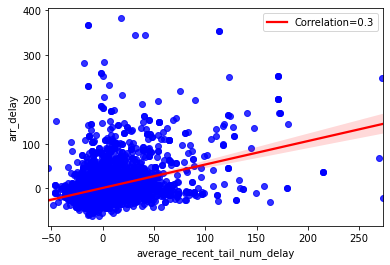

In [127]:
from scipy.stats import pearsonr
corr, _ = pearsonr(X_corr_check.last_delay, X_corr_check.arr_delay)

ax = sns.regplot(x='last_delay', y='arr_delay', data=X_sample,
                 line_kws={'label':"Correlation={0:.1f}".format(corr), "color": "red"},
                 scatter_kws={"color": "blue"})
ax.legend()
ax.set_xlabel('average_recent_tail_num_delay')

plt.show()


The "average recent tail number" is a dynamic average meaning it changes with time. So, the correlation must be considered at specific time and the correlation change with time. It shows good correlation with the target variable, in general. 

## Removing Outliers

In [52]:
outliers_filter1 = X_sample['arr_delay']<=500
outliers_filter2 = X_sample['last_delay']<=300
X_sample = X_sample[outliers_filter1&outliers_filter2]


In [53]:
X_sample.head()

,fl_date,tail_num,origin,dest,arr_delay,origin_rain,dest_rain,origin_fog,dest_fog,origin_cold,dest_cold,origin_storm,dest_storm,origin_precipitation,dest_precipitation,origin_snow,dest_snow,origin_hail,dest_hail,last_delay
0,2019-01-02,N741UW,FLL,PHL,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.333333
1,2019-01-02,N741UW,FLL,PHL,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.333333
2,2019-01-03,N8775A,DTW,ELM,-16.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,-18.250000
3,2019-01-06,N561UW,ORD,CLT,-26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,2019-01-06,N561UW,ORD,CLT,-26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


## Data Preparation

In [54]:
X = pd.DataFrame({'origin':X_sample.origin.astype("category").cat.codes, 'dest':X_sample.dest.astype("category").cat.codes})

other_columns = ['arr_delay', 'origin_rain','dest_rain', 'origin_fog', 'dest_fog', 'origin_cold', 'dest_cold','origin_storm',
                 'dest_storm', 'origin_precipitation','dest_precipitation', 'origin_snow', 'dest_snow', 'origin_hail','dest_hail',
                 'last_delay']
for column in other_columns:
    X[column] = X_sample[column]

X['day_of_year'] = pd.to_datetime(X_sample['fl_date']).dt.dayofyear

y= X['arr_delay']
X = X.drop('arr_delay',1)



## Scaling the data

In [55]:
import sklearn.model_selection as model_selection
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)


X_train, X_val, y_train, y_val = model_selection.train_test_split(X_scaled,y, train_size = 0.8, test_size=0.2, random_state=123)


## Machine Learning using "Random Forest Regression"

In [84]:
#Baseline Model
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators = 300, max_depth = 3)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

from sklearn.metrics import r2_score, mean_absolute_error
print('Baseline R2-Score = ', r2_score(y_val,y_pred))
print('Baseline Mean Square Error = ',mean_absolute_error(y_val,y_pred))


Baseline R2-Score =  0.2225347849164565
Baseline Mean Square Error =  19.610735195062603


### Optimizing the model parameter using "Grid Search"

In [113]:
from sklearn.model_selection import GridSearchCV
params = {'n_estimators': [200,250,300,350,400], 'max_depth': [15,20,25,30,35]}
model = RandomForestRegressor()
model_GS = GridSearchCV(model, param_grid=params, n_jobs=-1)
model_GS.fit(X_train,y_train)

GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [15, 20, 25, 30, 35],
                         'n_estimators': [200, 250, 300, 350, 400]})

In [114]:
best_model = model_GS.best_params_
print('Best Random Forest Model = ', best_model)

Best Random Forest Model =  {'max_depth': 30, 'n_estimators': 300}


In [115]:
best_estimator = model_GS.best_estimator_
y_pred = best_estimator.predict(X_val)
print('Best RandomForest Model R2-Score = ', r2_score(y_val,y_pred))
print('Best RandomForest Model Mean Square Error = ', mean_absolute_error(y_val,y_pred))

Best RandomForest Model R2-Score =  0.48270288216878066
Best RandomForest Model Mean Square Error =  14.534600596254142


## Machine Learning using "Decision Tree Regression"

In [80]:
#Baseline Model
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(max_depth = 5)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

from sklearn.metrics import r2_score, mean_absolute_error
print('Baseline DecisionTree R2-Score = ', r2_score(y_val,y_pred))
print('Baseline DecisionTree Mean Square Error = ',mean_absolute_error(y_val,y_pred))

Baseline R2-Score =  0.19824138652231993
Baseline Mean Square Error =  19.83266909138423


### Optimizing the model parameter using "Grid Search"

In [81]:
from sklearn.model_selection import GridSearchCV
params = {'max_depth': [3,4,5,6,7,8,9,10]}
model = DecisionTreeRegressor()
model_GS = GridSearchCV(model, param_grid=params, n_jobs=-1)
model_GS.fit(X_train,y_train)

GridSearchCV(estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10]})

In [82]:
best_model = model_GS.best_params_
print('Best DecisionTree Model = ', best_model)

Best Model =  {'max_depth': 5}


In [83]:
best_estimator = model_GS.best_estimator_
y_pred = best_estimator.predict(X_val)
print('Best DecisionTree Model R2-Score = ', r2_score(y_val,y_pred))
print('Best DecisionTree Model Mean Square Error = ', mean_absolute_error(y_val,y_pred))

Best Model R2-Score =  0.19824138652231993
Best Model Mean Square Error =  19.83266909138423
